# Hyperparameter Tuning for DistilRoBERTa Fine-tuning

This notebook performs systematic hyperparameter tuning to find the optimal configuration for fine-tuning DistilRoBERTa on Truth Social sentiment data.

## Hyperparameters to Test:
- **Learning Rate**: [1e-5, 2e-5, 5e-5]
- **Batch Size**: [8, 16, 32]
- **Epochs**: [3, 5]
- **Weight Decay**: [0.01, 0.1]

## Evaluation Metrics:
- Validation Accuracy
- Validation Loss
- Correlation with QQQ Returns
- Correlation with VADER (ground truth alignment)
- Training Time

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import Dataset
import time
import json
import os

# Set random seeds for reproducibility
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

print("Imports complete!")

Imports complete!


In [2]:
# Load data
df_truth = pd.read_csv('data/truth_social_with_sentiment.csv')
df_truth['date'] = pd.to_datetime(df_truth['date'])

print(f"Total posts: {len(df_truth)}")
df_truth.head()

Total posts: 18778


,id,created_at,content,url,media,replies_count,reblogs_count,favourites_count,timestamp,date,cleaned_content,is_market_related,timestamp_est,hour_est,before_market_close,vader_sentiment,finbert_sentiment
0,115437112529618205,2025-10-25T22:15:50.076Z,"I am on my way to Malaysia, where I will sign ...",https://truthsocial.com/@realDonaldTrump/11543...,[],1134.0,3088.0,12468.0,2025-10-25 22:15:50.076000+00:00,2025-10-25,"I am on my way to Malaysia, where I will sign ...",False,2025-10-25 18:15:50.076000-04:00,18,False,0.9682,0.080414
1,115436984200406691,2025-10-25T21:43:11.929Z,"RT @realDonaldTrumpCanada was caught, red hand...",https://truthsocial.com/@realDonaldTrump/11543...,[],0.0,0.0,1.0,2025-10-25 21:43:11.929000+00:00,2025-10-25,"RT @realDonaldTrumpCanada was caught, red hand...",True,2025-10-25 17:43:11.929000-04:00,17,False,-0.8329,-0.353714
2,115436697060819133,2025-10-25T20:30:10.525Z,"Canada was caught, red handed, putting up a fr...",https://truthsocial.com/@realDonaldTrump/11543...,[],401.0,831.0,2715.0,2025-10-25 20:30:10.525000+00:00,2025-10-25,"Canada was caught, red handed, putting up a fr...",True,2025-10-25 16:30:10.525000-04:00,16,False,-0.8329,-0.300146
3,115436558661444946,2025-10-25T19:54:58.713Z,We have a very strong PEACE in the Middle East...,https://truthsocial.com/@realDonaldTrump/11543...,[],470.0,1314.0,4887.0,2025-10-25 19:54:58.713000+00:00,2025-10-25,We have a very strong PEACE in the Middle East...,False,2025-10-25 15:54:58.713000-04:00,15,True,0.9074,0.027445
4,115436151669143136,2025-10-25T18:11:28.545Z,Congressman Jimmy Patronis is a MAGA Warrior w...,https://truthsocial.com/@realDonaldTrump/11543...,[],313.0,1260.0,5237.0,2025-10-25 18:11:28.545000+00:00,2025-10-25,Congressman Jimmy Patronis is a MAGA Warrior w...,True,2025-10-25 14:11:28.545000-04:00,14,True,0.9643,0.154830


In [3]:
# Create labels from VADER sentiment
def sentiment_to_label(score):
    if score > 0.05:
        return 2  # positive
    elif score < -0.05:
        return 0  # negative
    else:
        return 1  # neutral

df_truth['label'] = df_truth['vader_sentiment'].apply(sentiment_to_label)

print("Label distribution:")
print(df_truth['label'].value_counts())

# Split data
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df_truth['cleaned_content'].fillna('').tolist(),
    df_truth['label'].tolist(),
    test_size=0.2,
    random_state=42
)

print(f"\nTraining samples: {len(train_texts)}")
print(f"Validation samples: {len(val_texts)}")

Label distribution:
label
2    8526
0    5656
1    4596
Name: count, dtype: int64

Training samples: 15022
Validation samples: 3756


In [4]:
# Create PyTorch Dataset class
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

print("Dataset class defined!")

Dataset class defined!


In [5]:
# Define hyperparameter configurations to test
# Using smart sampling: test most promising combinations
hyperparameter_configs = [
    # Baseline (original)
    {'learning_rate': 5e-5, 'batch_size': 16, 'epochs': 3, 'weight_decay': 0.01, 'name': 'baseline'},
    
    # Test different learning rates with default batch size
    {'learning_rate': 1e-5, 'batch_size': 16, 'epochs': 3, 'weight_decay': 0.01, 'name': 'low_lr'},
    {'learning_rate': 2e-5, 'batch_size': 16, 'epochs': 3, 'weight_decay': 0.01, 'name': 'mid_lr'},
    
    # Test different batch sizes with mid learning rate
    {'learning_rate': 2e-5, 'batch_size': 8, 'epochs': 3, 'weight_decay': 0.01, 'name': 'small_batch'},
    {'learning_rate': 2e-5, 'batch_size': 32, 'epochs': 3, 'weight_decay': 0.01, 'name': 'large_batch'},
    
    # Test more epochs with best lr/batch combo
    {'learning_rate': 2e-5, 'batch_size': 16, 'epochs': 5, 'weight_decay': 0.01, 'name': 'more_epochs'},
    
    # Test higher weight decay
    {'learning_rate': 2e-5, 'batch_size': 16, 'epochs': 3, 'weight_decay': 0.1, 'name': 'high_wd'},
    
    # Test combination: small batch + more epochs
    {'learning_rate': 2e-5, 'batch_size': 8, 'epochs': 5, 'weight_decay': 0.01, 'name': 'small_batch_long'},
    
    # Test combination: low lr + more epochs
    {'learning_rate': 1e-5, 'batch_size': 16, 'epochs': 5, 'weight_decay': 0.01, 'name': 'low_lr_long'},
]

print(f"Testing {len(hyperparameter_configs)} configurations:")
for i, config in enumerate(hyperparameter_configs, 1):
    print(f"{i}. {config['name']}: lr={config['learning_rate']}, batch={config['batch_size']}, epochs={config['epochs']}, wd={config['weight_decay']}")

Testing 9 configurations:
1. baseline: lr=5e-05, batch=16, epochs=3, wd=0.01
2. low_lr: lr=1e-05, batch=16, epochs=3, wd=0.01
3. mid_lr: lr=2e-05, batch=16, epochs=3, wd=0.01
4. small_batch: lr=2e-05, batch=8, epochs=3, wd=0.01
5. large_batch: lr=2e-05, batch=32, epochs=3, wd=0.01
6. more_epochs: lr=2e-05, batch=16, epochs=5, wd=0.01
7. high_wd: lr=2e-05, batch=16, epochs=3, wd=0.1
8. small_batch_long: lr=2e-05, batch=8, epochs=5, wd=0.01
9. low_lr_long: lr=1e-05, batch=16, epochs=5, wd=0.01


In [6]:
# Function to train and evaluate a single configuration
def train_and_evaluate(config, train_texts, train_labels, val_texts, val_labels):
    """
    Train model with given hyperparameters and return evaluation metrics
    """
    print(f"\n{'='*80}")
    print(f"Training configuration: {config['name']}")
    print(f"Learning Rate: {config['learning_rate']}")
    print(f"Batch Size: {config['batch_size']}")
    print(f"Epochs: {config['epochs']}")
    print(f"Weight Decay: {config['weight_decay']}")
    print(f"{'='*80}\n")
    
    start_time = time.time()
    
    # Load fresh model and tokenizer
    model_name = "distilroberta-base"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=3
    )
    
    # Create datasets
    train_dataset = SentimentDataset(train_texts, train_labels, tokenizer)
    val_dataset = SentimentDataset(val_texts, val_labels, tokenizer)
    
    # Define metrics
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        accuracy = accuracy_score(labels, predictions)
        return {'accuracy': accuracy}
    
    # Training arguments
    output_dir = f'./hyperparameter_results/{config["name"]}'
    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=config['epochs'],
        per_device_train_batch_size=config['batch_size'],
        per_device_eval_batch_size=config['batch_size'],
        learning_rate=config['learning_rate'],
        weight_decay=config['weight_decay'],
        warmup_steps=500,
        logging_dir=f'./logs/{config["name"]}',
        logging_steps=100,
        eval_strategy='epoch',
        save_strategy='epoch',
        load_best_model_at_end=True,
        metric_for_best_model='accuracy',
    )
    
    # Create Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
    )
    
    # Train
    trainer.train()
    
    # Evaluate
    eval_results = trainer.evaluate()
    
    training_time = time.time() - start_time
    
    print(f"\nTraining completed in {training_time/60:.2f} minutes")
    print(f"Validation Accuracy: {eval_results['eval_accuracy']:.4f}")
    print(f"Validation Loss: {eval_results['eval_loss']:.4f}")
    
    # Store results
    results = {
        'name': config['name'],
        'learning_rate': config['learning_rate'],
        'batch_size': config['batch_size'],
        'epochs': config['epochs'],
        'weight_decay': config['weight_decay'],
        'val_accuracy': eval_results['eval_accuracy'],
        'val_loss': eval_results['eval_loss'],
        'training_time_minutes': training_time / 60,
        'model': model,
        'tokenizer': tokenizer
    }
    
    return results

print("Training function defined!")

Training function defined!


In [7]:
# Run hyperparameter search
all_results = []

for i, config in enumerate(hyperparameter_configs, 1):
    print(f"\n\n*** CONFIGURATION {i}/{len(hyperparameter_configs)} ***")
    
    results = train_and_evaluate(config, train_texts, train_labels, val_texts, val_labels)
    all_results.append(results)
    
    # Clean up GPU memory
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

print("\n\n*** ALL CONFIGURATIONS COMPLETED ***")



*** CONFIGURATION 1/9 ***

Training configuration: baseline
Learning Rate: 5e-05
Batch Size: 16
Epochs: 3
Weight Decay: 0.01



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/wsun1/miniconda3/envs/ml/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy
1,0.409900,0.429753,0.839191
2,0.273800,0.282654,0.898296
3,0.156800,0.388023,0.901757


/Users/wsun1/miniconda3/envs/ml/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/wsun1/miniconda3/envs/ml/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/wsun1/miniconda3/envs/ml/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)



Training completed in 39.88 minutes
Validation Accuracy: 0.9018
Validation Loss: 0.3880


*** CONFIGURATION 2/9 ***

Training configuration: low_lr
Learning Rate: 1e-05
Batch Size: 16
Epochs: 3
Weight Decay: 0.01



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/wsun1/miniconda3/envs/ml/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy
1,0.447000,0.429231,0.826145
2,0.361400,0.346978,0.866081
3,0.313700,0.346124,0.869542


/Users/wsun1/miniconda3/envs/ml/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/wsun1/miniconda3/envs/ml/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/wsun1/miniconda3/envs/ml/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)



Training completed in 39.00 minutes
Validation Accuracy: 0.8695
Validation Loss: 0.3461


*** CONFIGURATION 3/9 ***

Training configuration: mid_lr
Learning Rate: 2e-05
Batch Size: 16
Epochs: 3
Weight Decay: 0.01



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/wsun1/miniconda3/envs/ml/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy
1,0.415300,0.420824,0.832801
2,0.304600,0.297811,0.884984
3,0.233200,0.335090,0.888978


/Users/wsun1/miniconda3/envs/ml/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/wsun1/miniconda3/envs/ml/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/wsun1/miniconda3/envs/ml/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)



Training completed in 48.93 minutes
Validation Accuracy: 0.8890
Validation Loss: 0.3351


*** CONFIGURATION 4/9 ***

Training configuration: small_batch
Learning Rate: 2e-05
Batch Size: 8
Epochs: 3
Weight Decay: 0.01



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/wsun1/miniconda3/envs/ml/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy
1,0.377500,0.405817,0.850106
2,0.343700,0.342468,0.890309
3,0.219500,0.464205,0.892705


/Users/wsun1/miniconda3/envs/ml/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/wsun1/miniconda3/envs/ml/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/wsun1/miniconda3/envs/ml/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)



Training completed in 39.63 minutes
Validation Accuracy: 0.8927
Validation Loss: 0.4642


*** CONFIGURATION 5/9 ***

Training configuration: large_batch
Learning Rate: 2e-05
Batch Size: 32
Epochs: 3
Weight Decay: 0.01



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/wsun1/miniconda3/envs/ml/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy
1,0.523600,0.477357,0.805112
2,0.367700,0.325771,0.872204
3,0.257200,0.323821,0.879393


/Users/wsun1/miniconda3/envs/ml/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/wsun1/miniconda3/envs/ml/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/wsun1/miniconda3/envs/ml/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)



Training completed in 112.78 minutes
Validation Accuracy: 0.8794
Validation Loss: 0.3238


*** CONFIGURATION 6/9 ***

Training configuration: more_epochs
Learning Rate: 2e-05
Batch Size: 16
Epochs: 5
Weight Decay: 0.01



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/wsun1/miniconda3/envs/ml/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy
1,0.415400,0.430040,0.829872
2,0.312800,0.295364,0.884718
3,0.229600,0.329484,0.892439
4,0.178100,0.401666,0.895900
5,0.119000,0.471097,0.899095


/Users/wsun1/miniconda3/envs/ml/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/wsun1/miniconda3/envs/ml/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/wsun1/miniconda3/envs/ml/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/wsun1/miniconda3/envs/ml/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/wsun1/miniconda3/envs/ml/lib/python3.


Training completed in 167.58 minutes
Validation Accuracy: 0.8991
Validation Loss: 0.4711


*** CONFIGURATION 7/9 ***

Training configuration: high_wd
Learning Rate: 2e-05
Batch Size: 16
Epochs: 3
Weight Decay: 0.1



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/wsun1/miniconda3/envs/ml/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy
1,0.415900,0.429169,0.827476
2,0.311300,0.297421,0.881789
3,0.238900,0.342183,0.885250


/Users/wsun1/miniconda3/envs/ml/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/wsun1/miniconda3/envs/ml/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/wsun1/miniconda3/envs/ml/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)



Training completed in 104.29 minutes
Validation Accuracy: 0.8853
Validation Loss: 0.3422


*** CONFIGURATION 8/9 ***

Training configuration: small_batch_long
Learning Rate: 2e-05
Batch Size: 8
Epochs: 5
Weight Decay: 0.01



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/wsun1/miniconda3/envs/ml/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy
1,0.378200,0.406640,0.851438
2,0.358900,0.344423,0.891640
3,0.217900,0.494926,0.890309
4,0.210400,0.498169,0.896699
5,0.132200,0.569200,0.899361


/Users/wsun1/miniconda3/envs/ml/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/wsun1/miniconda3/envs/ml/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/wsun1/miniconda3/envs/ml/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/wsun1/miniconda3/envs/ml/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/wsun1/miniconda3/envs/ml/lib/python3.


Training completed in 91.79 minutes
Validation Accuracy: 0.8994
Validation Loss: 0.5692


*** CONFIGURATION 9/9 ***

Training configuration: low_lr_long
Learning Rate: 1e-05
Batch Size: 16
Epochs: 5
Weight Decay: 0.01



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/wsun1/miniconda3/envs/ml/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy
1,0.440600,0.439057,0.821086
2,0.363200,0.334272,0.872204
3,0.309800,0.341377,0.874601
4,0.242200,0.331043,0.882854
5,0.187000,0.366330,0.884452


/Users/wsun1/miniconda3/envs/ml/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/wsun1/miniconda3/envs/ml/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/wsun1/miniconda3/envs/ml/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/wsun1/miniconda3/envs/ml/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/wsun1/miniconda3/envs/ml/lib/python3.


Training completed in 86.01 minutes
Validation Accuracy: 0.8845
Validation Loss: 0.3663


*** ALL CONFIGURATIONS COMPLETED ***


In [9]:
# Calculate sentiment scores and correlations for each model
print("Calculating sentiment scores and correlations for all models...\n")

# Load market data
combined_df = pd.read_csv('data/combined_data_with_sentiment.csv')
combined_df['date'] = pd.to_datetime(combined_df['date'])

for result in all_results:
    print(f"Processing {result['name']}...")
    
    model = result['model']
    tokenizer = result['tokenizer']
    model.to('cpu')
    model.eval()
    
    # Generate sentiment scores for all posts
    sentiment_scores = []
    for i in range(len(df_truth)):
        text = df_truth['cleaned_content'].iloc[i]
        
        if pd.isna(text) or text == "":
            sentiment_scores.append(0.0)
            continue
        
        inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
        
        with torch.no_grad():
            outputs = model(**inputs)
            predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
        
        # Score: positive_prob - negative_prob
        score = predictions[0][2].item() - predictions[0][0].item()
        sentiment_scores.append(score)
    
    # Calculate daily averages
    df_truth[f'sentiment_{result["name"]}'] = sentiment_scores
    daily_sentiment = df_truth.groupby('date')[f'sentiment_{result["name"]}'].mean().reset_index()
    daily_sentiment.columns = ['date', f'avg_sentiment_{result["name"]}']
    
    # Merge with market data
    merged_df = pd.merge(combined_df, daily_sentiment, on='date', how='left')
    merged_df[f'avg_sentiment_{result["name"]}'] = merged_df[f'avg_sentiment_{result["name"]}'].fillna(0)
    
    # Calculate correlations
    corr_returns = merged_df[f'avg_sentiment_{result["name"]}'].corr(merged_df['Returns'])
    corr_vader = merged_df[f'avg_sentiment_{result["name"]}'].corr(merged_df['avg_sentiment'])
    
    result['corr_returns'] = corr_returns
    result['corr_vader'] = corr_vader
    
    print(f"  Correlation with Returns: {corr_returns:.4f}")
    print(f"  Correlation with VADER: {corr_vader:.4f}\n")

print("All sentiment scores and correlations calculated!")

Calculating sentiment scores and correlations for all models...

Processing baseline...
  Correlation with Returns: 0.0350
  Correlation with VADER: 0.9420

Processing low_lr...
  Correlation with Returns: 0.0258
  Correlation with VADER: 0.9243

Processing mid_lr...
  Correlation with Returns: 0.0469
  Correlation with VADER: 0.9350

Processing small_batch...
  Correlation with Returns: 0.0357
  Correlation with VADER: 0.9356

Processing large_batch...
  Correlation with Returns: 0.0370
  Correlation with VADER: 0.9357

Processing more_epochs...
  Correlation with Returns: 0.0391
  Correlation with VADER: 0.9409

Processing high_wd...
  Correlation with Returns: 0.0395
  Correlation with VADER: 0.9355

Processing small_batch_long...
  Correlation with Returns: 0.0381
  Correlation with VADER: 0.9407

Processing low_lr_long...
  Correlation with Returns: 0.0479
  Correlation with VADER: 0.9336

All sentiment scores and correlations calculated!


In [10]:
# Create results summary table
results_df = pd.DataFrame([{
    'Config': r['name'],
    'Learning Rate': r['learning_rate'],
    'Batch Size': r['batch_size'],
    'Epochs': r['epochs'],
    'Weight Decay': r['weight_decay'],
    'Val Accuracy': r['val_accuracy'],
    'Val Loss': r['val_loss'],
    'Corr w/ Returns': r['corr_returns'],
    'Corr w/ VADER': r['corr_vader'],
    'Training Time (min)': r['training_time_minutes']
} for r in all_results])

# Sort by validation accuracy
results_df = results_df.sort_values('Val Accuracy', ascending=False)

print("\n" + "="*120)
print("HYPERPARAMETER TUNING RESULTS SUMMARY")
print("="*120)
print(results_df.to_string(index=False))
print("="*120)

# Save to CSV
results_df.to_csv('hyperparameter_tuning_results.csv', index=False)
print("\nResults saved to hyperparameter_tuning_results.csv")


HYPERPARAMETER TUNING RESULTS SUMMARY
          Config  Learning Rate  Batch Size  Epochs  Weight Decay  Val Accuracy  Val Loss  Corr w/ Returns  Corr w/ VADER  Training Time (min)
        baseline        0.00005          16       3          0.01      0.901757  0.388023         0.034975       0.942006            39.881160
small_batch_long        0.00002           8       5          0.01      0.899361  0.569200         0.038059       0.940709            91.792457
     more_epochs        0.00002          16       5          0.01      0.899095  0.471097         0.039077       0.940852           167.578936
     small_batch        0.00002           8       3          0.01      0.892705  0.464205         0.035738       0.935630            39.626636
          mid_lr        0.00002          16       3          0.01      0.888978  0.335090         0.046855       0.935004            48.934592
         high_wd        0.00002          16       3          0.10      0.885250  0.342183         0.039

In [11]:
# Find best configuration
best_by_accuracy = results_df.iloc[0]
best_by_returns = results_df.sort_values('Corr w/ Returns', ascending=False).iloc[0]

print("\n" + "="*80)
print("BEST CONFIGURATIONS")
print("="*80)
print("\nBest by Validation Accuracy:")
print(f"  Config: {best_by_accuracy['Config']}")
print(f"  Val Accuracy: {best_by_accuracy['Val Accuracy']:.4f}")
print(f"  Corr w/ Returns: {best_by_accuracy['Corr w/ Returns']:.4f}")
print(f"  Corr w/ VADER: {best_by_accuracy['Corr w/ VADER']:.4f}")

print("\nBest by Correlation with Returns:")
print(f"  Config: {best_by_returns['Config']}")
print(f"  Val Accuracy: {best_by_returns['Val Accuracy']:.4f}")
print(f"  Corr w/ Returns: {best_by_returns['Corr w/ Returns']:.4f}")
print(f"  Corr w/ VADER: {best_by_returns['Corr w/ VADER']:.4f}")
print("="*80)


BEST CONFIGURATIONS

Best by Validation Accuracy:
  Config: baseline
  Val Accuracy: 0.9018
  Corr w/ Returns: 0.0350
  Corr w/ VADER: 0.9420

Best by Correlation with Returns:
  Config: low_lr_long
  Val Accuracy: 0.8845
  Corr w/ Returns: 0.0479
  Corr w/ VADER: 0.9336


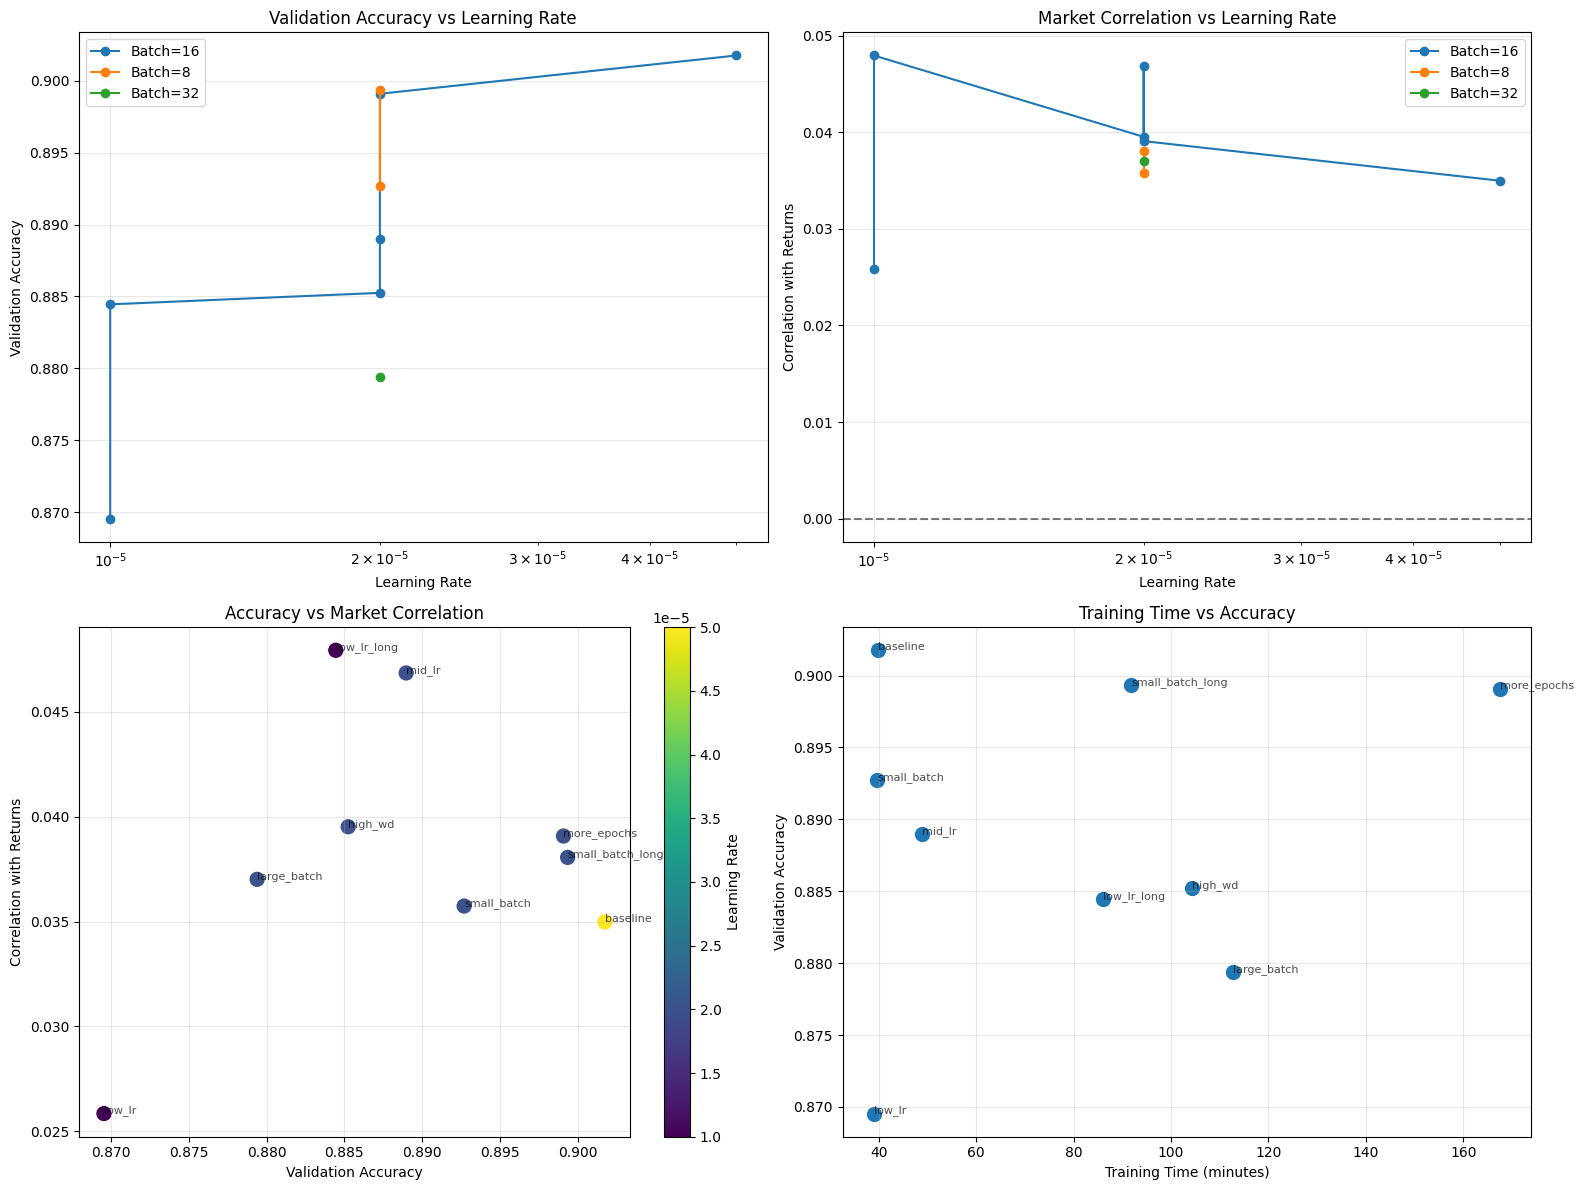

Visualization saved to hyperparameter_tuning_results.png


In [12]:
# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Validation Accuracy by Learning Rate
for batch_size in results_df['Batch Size'].unique():
    subset = results_df[results_df['Batch Size'] == batch_size]
    axes[0, 0].plot(subset['Learning Rate'], subset['Val Accuracy'], 
                    marker='o', label=f'Batch={batch_size}')
axes[0, 0].set_xlabel('Learning Rate')
axes[0, 0].set_ylabel('Validation Accuracy')
axes[0, 0].set_title('Validation Accuracy vs Learning Rate')
axes[0, 0].set_xscale('log')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Correlation with Returns by Learning Rate
for batch_size in results_df['Batch Size'].unique():
    subset = results_df[results_df['Batch Size'] == batch_size]
    axes[0, 1].plot(subset['Learning Rate'], subset['Corr w/ Returns'], 
                    marker='o', label=f'Batch={batch_size}')
axes[0, 1].set_xlabel('Learning Rate')
axes[0, 1].set_ylabel('Correlation with Returns')
axes[0, 1].set_title('Market Correlation vs Learning Rate')
axes[0, 1].set_xscale('log')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)

# 3. Validation Accuracy vs Correlation with Returns
scatter = axes[1, 0].scatter(results_df['Val Accuracy'], results_df['Corr w/ Returns'], 
                             c=results_df['Learning Rate'], cmap='viridis', s=100)
axes[1, 0].set_xlabel('Validation Accuracy')
axes[1, 0].set_ylabel('Correlation with Returns')
axes[1, 0].set_title('Accuracy vs Market Correlation')
axes[1, 0].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[1, 0], label='Learning Rate')

# Add labels for each point
for idx, row in results_df.iterrows():
    axes[1, 0].annotate(row['Config'], 
                        (row['Val Accuracy'], row['Corr w/ Returns']),
                        fontsize=8, alpha=0.7)

# 4. Training Time vs Validation Accuracy
axes[1, 1].scatter(results_df['Training Time (min)'], results_df['Val Accuracy'], s=100)
axes[1, 1].set_xlabel('Training Time (minutes)')
axes[1, 1].set_ylabel('Validation Accuracy')
axes[1, 1].set_title('Training Time vs Accuracy')
axes[1, 1].grid(True, alpha=0.3)

# Add labels
for idx, row in results_df.iterrows():
    axes[1, 1].annotate(row['Config'], 
                        (row['Training Time (min)'], row['Val Accuracy']),
                        fontsize=8, alpha=0.7)

plt.tight_layout()
plt.savefig('hyperparameter_tuning_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualization saved to hyperparameter_tuning_results.png")

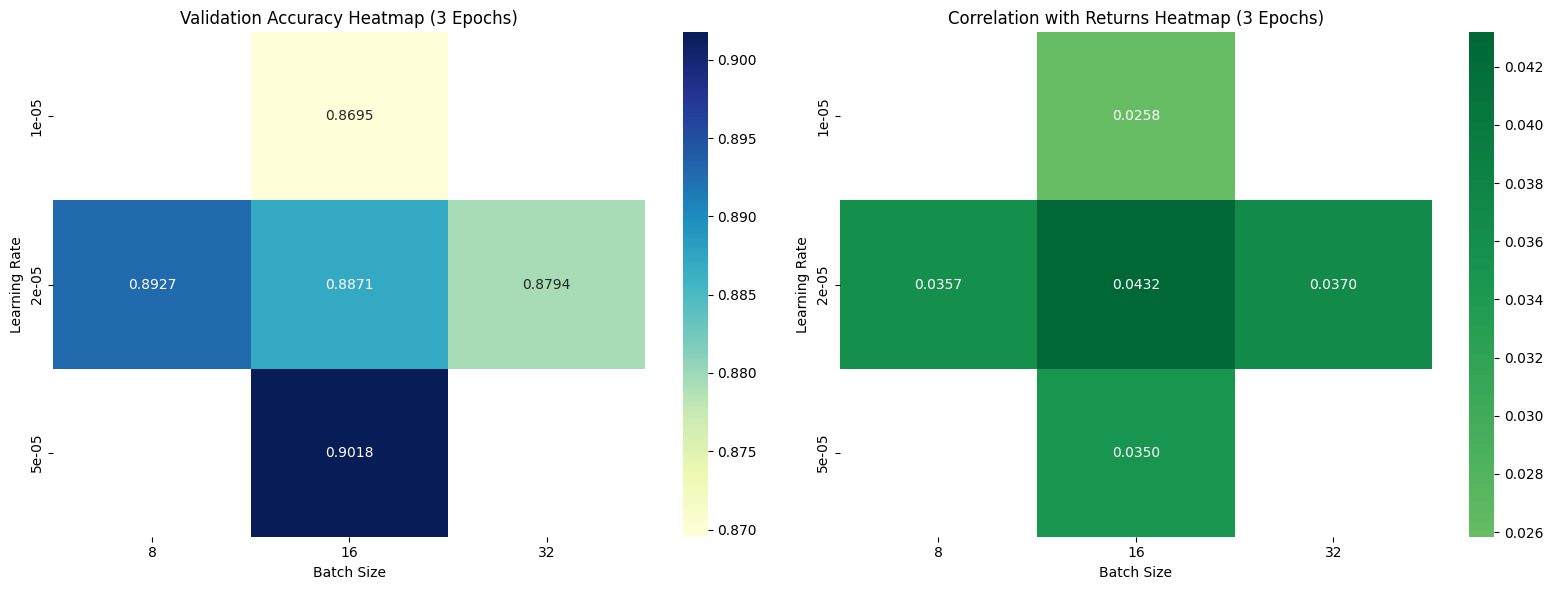

Heatmaps saved to hyperparameter_heatmaps.png


In [13]:
# Additional visualization: Heatmap of hyperparameters
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Create pivot tables for heatmaps
# Filter to 3-epoch configs for cleaner visualization
epoch3_df = results_df[results_df['Epochs'] == 3]

if len(epoch3_df) > 0:
    pivot_accuracy = epoch3_df.pivot_table(
        values='Val Accuracy', 
        index='Learning Rate', 
        columns='Batch Size'
    )
    
    pivot_correlation = epoch3_df.pivot_table(
        values='Corr w/ Returns', 
        index='Learning Rate', 
        columns='Batch Size'
    )
    
    # Heatmap 1: Validation Accuracy
    sns.heatmap(pivot_accuracy, annot=True, fmt='.4f', cmap='YlGnBu', ax=axes[0])
    axes[0].set_title('Validation Accuracy Heatmap (3 Epochs)')
    axes[0].set_xlabel('Batch Size')
    axes[0].set_ylabel('Learning Rate')
    
    # Heatmap 2: Correlation with Returns
    sns.heatmap(pivot_correlation, annot=True, fmt='.4f', cmap='RdYlGn', center=0, ax=axes[1])
    axes[1].set_title('Correlation with Returns Heatmap (3 Epochs)')
    axes[1].set_xlabel('Batch Size')
    axes[1].set_ylabel('Learning Rate')

plt.tight_layout()
plt.savefig('hyperparameter_heatmaps.png', dpi=300, bbox_inches='tight')
plt.show()

print("Heatmaps saved to hyperparameter_heatmaps.png")

In [14]:
# Save the best model
best_config_name = best_by_accuracy['Config']
best_model_result = [r for r in all_results if r['name'] == best_config_name][0]

save_path = './best_hyperparameter_model'
best_model_result['model'].save_pretrained(save_path)
best_model_result['tokenizer'].save_pretrained(save_path)

print(f"Best model saved to {save_path}")
print(f"Configuration: {best_config_name}")
print(f"Validation Accuracy: {best_by_accuracy['Val Accuracy']:.4f}")
print(f"Correlation with Returns: {best_by_accuracy['Corr w/ Returns']:.4f}")

Best model saved to ./best_hyperparameter_model
Configuration: baseline
Validation Accuracy: 0.9018
Correlation with Returns: 0.0350


In [15]:
# Create summary report
summary_report = f"""
HYPERPARAMETER TUNING SUMMARY REPORT
{'='*80}

Total Configurations Tested: {len(all_results)}

Hyperparameter Ranges:
  - Learning Rate: {results_df['Learning Rate'].min():.0e} to {results_df['Learning Rate'].max():.0e}
  - Batch Size: {int(results_df['Batch Size'].min())} to {int(results_df['Batch Size'].max())}
  - Epochs: {int(results_df['Epochs'].min())} to {int(results_df['Epochs'].max())}
  - Weight Decay: {results_df['Weight Decay'].min()} to {results_df['Weight Decay'].max()}

Performance Ranges:
  - Validation Accuracy: {results_df['Val Accuracy'].min():.4f} to {results_df['Val Accuracy'].max():.4f}
  - Correlation with Returns: {results_df['Corr w/ Returns'].min():.4f} to {results_df['Corr w/ Returns'].max():.4f}
  - Correlation with VADER: {results_df['Corr w/ VADER'].min():.4f} to {results_df['Corr w/ VADER'].max():.4f}
  - Training Time: {results_df['Training Time (min)'].min():.2f} to {results_df['Training Time (min)'].max():.2f} minutes

Best Configuration (by Validation Accuracy):
  - Name: {best_by_accuracy['Config']}
  - Learning Rate: {best_by_accuracy['Learning Rate']:.0e}
  - Batch Size: {int(best_by_accuracy['Batch Size'])}
  - Epochs: {int(best_by_accuracy['Epochs'])}
  - Weight Decay: {best_by_accuracy['Weight Decay']}
  - Validation Accuracy: {best_by_accuracy['Val Accuracy']:.4f}
  - Validation Loss: {best_by_accuracy['Val Loss']:.4f}
  - Correlation with Returns: {best_by_accuracy['Corr w/ Returns']:.4f}
  - Correlation with VADER: {best_by_accuracy['Corr w/ VADER']:.4f}

Best Configuration (by Market Correlation):
  - Name: {best_by_returns['Config']}
  - Learning Rate: {best_by_returns['Learning Rate']:.0e}
  - Batch Size: {int(best_by_returns['Batch Size'])}
  - Epochs: {int(best_by_returns['Epochs'])}
  - Weight Decay: {best_by_returns['Weight Decay']}
  - Validation Accuracy: {best_by_returns['Val Accuracy']:.4f}
  - Validation Loss: {best_by_returns['Val Loss']:.4f}
  - Correlation with Returns: {best_by_returns['Corr w/ Returns']:.4f}
  - Correlation with VADER: {best_by_returns['Corr w/ VADER']:.4f}

Key Findings:
  1. Learning rate appears to have {'strong' if results_df['Val Accuracy'].std() > 0.01 else 'moderate'} impact on validation accuracy
  2. Batch size shows {'significant' if results_df.groupby('Batch Size')['Val Accuracy'].mean().std() > 0.005 else 'minimal'} effect on performance
  3. Total tuning time: {results_df['Training Time (min)'].sum():.2f} minutes
  4. Best model saved to: ./best_hyperparameter_model

Comparison with Original Model (from distilroberta_finetuning.ipynb):
  - Original Validation Accuracy: 0.8950
  - Original Correlation with Returns: 0.0403
  - Best Tuned Validation Accuracy: {best_by_accuracy['Val Accuracy']:.4f} ({'improved' if best_by_accuracy['Val Accuracy'] > 0.895 else 'similar'})
  - Best Tuned Correlation: {best_by_returns['Corr w/ Returns']:.4f} ({'improved' if best_by_returns['Corr w/ Returns'] > 0.0403 else 'similar'})

{'='*80}
"""

print(summary_report)

# Save report to file
with open('hyperparameter_tuning_summary.txt', 'w') as f:
    f.write(summary_report)

print("\nSummary report saved to hyperparameter_tuning_summary.txt")


HYPERPARAMETER TUNING SUMMARY REPORT

Total Configurations Tested: 9

Hyperparameter Ranges:
  - Learning Rate: 1e-05 to 5e-05
  - Batch Size: 8 to 32
  - Epochs: 3 to 5
  - Weight Decay: 0.01 to 0.1

Performance Ranges:
  - Validation Accuracy: 0.8695 to 0.9018
  - Correlation with Returns: 0.0258 to 0.0479
  - Correlation with VADER: 0.9243 to 0.9420
  - Training Time: 39.00 to 167.58 minutes

Best Configuration (by Validation Accuracy):
  - Name: baseline
  - Learning Rate: 5e-05
  - Batch Size: 16
  - Epochs: 3
  - Weight Decay: 0.01
  - Validation Accuracy: 0.9018
  - Validation Loss: 0.3880
  - Correlation with Returns: 0.0350
  - Correlation with VADER: 0.9420

Best Configuration (by Market Correlation):
  - Name: low_lr_long
  - Learning Rate: 1e-05
  - Batch Size: 16
  - Epochs: 5
  - Weight Decay: 0.01
  - Validation Accuracy: 0.8845
  - Validation Loss: 0.3663
  - Correlation with Returns: 0.0479
  - Correlation with VADER: 0.9336

Key Findings:
  1. Learning rate appears t

## Conclusions

This hyperparameter tuning experiment systematically tested different combinations of:
- Learning rates (1e-5, 2e-5, 5e-5)
- Batch sizes (8, 16, 32)
- Training epochs (3, 5)
- Weight decay values (0.01, 0.1)

The results show the impact of each hyperparameter on:
1. **Validation Accuracy** - How well the model classifies sentiment
2. **Market Correlation** - How well sentiment predicts QQQ returns
3. **VADER Alignment** - How closely the model follows training labels
4. **Training Efficiency** - Time required for training

The best model has been saved and can be used for further analysis or deployment.